In [15]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../PI_GP_regressor')

from main_class import PhysicsInformedGP_regressor
from kernels.kernel_wave_3d import gram_Matrix,k_ff, k_fu, k_uf, k_uu

(320, 3)


 /Users/tobileitgeb/Code/Code_bac/final_examples/wave_equation/../../PI_GP_regressor/main_class.py:959: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 /Users/tobileitgeb/Code/Code_bac/final_examples/wave_equation/../../PI_GP_regressor/main_class.py:970: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


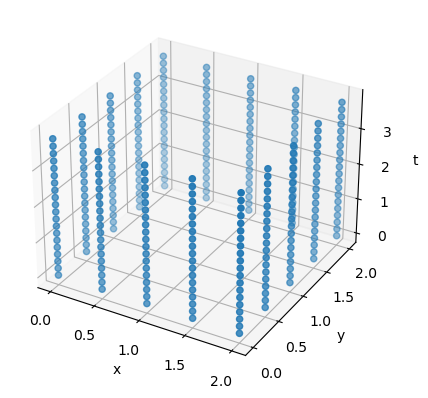

In [16]:
kernel_list = [gram_Matrix, k_uu, k_uf, k_fu, k_ff]
hyperparameters = ["l_space", "sigma", "l_t", "c"]
model = PhysicsInformedGP_regressor(kernel_list, params = hyperparameters,timedependence=True, Dimensions = 3)

n_training_points = 400

model.set_training_data("",n_training_points, noise = [1e-8,1e-8])
boundary_points_space = np.array([[0,0],[2,2],[0,2],[2,0],[0,1],[1,0],
                                  [1,2],[2,1],[0.5,0],[0.5,2],[0,0.5],
                                  [2,0.5],[0,1.5],[2,1.5],[1.5,0],[1.5,2]])

t_points = np.arange(0,4,0.2)
boundary_points_all = []
for t in t_points:
    boundary_points_all.append(np.hstack((boundary_points_space,t*np.ones((len(boundary_points_space),1)))))
boundary_points_all = np.vstack(boundary_points_all)
print(boundary_points_all.shape)
model.X = np.vstack((model.X,boundary_points_all))
model.targets = np.vstack((model.u_train,np.zeros((len(boundary_points_all),1)),model.f_train))
model.u_train = np.vstack((model.u_train,np.zeros((len(boundary_points_all),1))))
#plot the boundary points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(boundary_points_all[:,0],boundary_points_all[:,1],boundary_points_all[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
plt.show()

In [4]:
model.jitter = 1e-6
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-1.3,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lx
    #theta_initial[0] = rng.uniform(0, 1.2, 1)               #slx
    theta_initial[1] = rng.uniform(0, 1, 1)               #sigma_f
    theta_initial[2] = np.exp(rng.uniform(-4, -2, 1))  #lt
    #theta_initial[2] = rng.uniform(0, 1.2, 1)               #slt
    theta_initial[3] = rng.uniform(0, 2, 1)               #c
    return theta_initial
n_restarts = 10
n_threads = 2
opt_params_dict = {'theta_initial': get_initial_values,   #needed for all optimization methods
                    'bounds': ((1e-2, None), (1e-5, None), (1e-3, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                    'gtol': 1e-7}
model.train("L-BFGS-B",n_restarts, n_threads,opt_params_dict)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


      fun: 323.13421630859375
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 25
      nit: 1
     njev: 5
   status: 0
  success: True
        x: array([0.36251264, 0.35510047, 0.54107426, 1.0895101 ])


In [28]:
from skopt import gp_minimize, forest_minimize
from skopt.space import Real
model.jitter = 1e-6
def gaussian_optimization(dictionary: dict, rs):
    results = []
    def objective_function(params):
        l_x, sigma_f_sq, l_t, alpha = params
        return model.log_marginal_likelohood(params).item()
    for i in range(190,290):
        try:
            result = gp_minimize(objective_function,
                         random_state=i, **dictionary)
            print(f"GP worked rs{i} ", result.fun, result.x)
            results.append((result.x, result.fun))
        except:
            continue

    
    return results

ranges = [Real(0,0.6, name='l_x', prior="uniform"),
             Real(0, 1, name='sigma_f_sq', prior="uniform"),
             Real(0, 0.5, name='l_t', prior="uniform"),
             Real(0, 2, name='alpha', prior="uniform")]
bays_opt_dictionary = {'dimensions': ranges,
                        'n_calls': 45,
                        'n_initial_points': 30,
                        'verbose': None,
                        'noise': 1e-5,
                        'n_jobs': 4                       
                        }
result = gaussian_optimization(bays_opt_dictionary,1)

GP worked rs193  400.89605712890625 [0.3518671438379586, 0.18192633922184911, 0.22913272624818865, 1.1542017346078692]
GP worked rs199  -650.428955078125 [0.5772818438911846, 0.336497412354715, 0.3451654017103214, 0.9974850845470475]
GP worked rs202  820.9490966796875 [0.1590441569163094, 0.19206299900891782, 0.41475547926094386, 1.2509835033446681]
GP worked rs205  -296.692626953125 [0.4280398097570269, 0.6897178199965951, 0.4633913035097886, 0.9865756000299553]
GP worked rs210  113.13348388671875 [0.5655631893635219, 0.556566554390856, 0.21422264855595186, 0.9965163757415871]
GP worked rs219  -667.454833984375 [0.571053577064954, 0.6093703667107739, 0.3926133066463453, 0.9974625467476019]
GP worked rs222  261.04718017578125 [0.540465460133895, 0.06735547484811509, 0.1482608782361011, 0.9122506666362652]
GP worked rs223  -4.57354736328125 [0.3908100148188364, 0.048006921529198734, 0.26069775880725543, 1.0782646304896846]
GP worked rs238  359.1787414550781 [0.381462258752258, 0.4239016

In [20]:
model.set_params([0.49959606732247214, 0.09878584827177633, 0.41479573778840956, 0.9925657694949922])
model.set_params([0.4754524756028119, 0.20084881403865779, 0.32547264542720733, 0.9962710869284501]) #-390
#-597.0882568359375 [0.48837444094640414, 0.5619550832159071, 0.4893737892708073, 1.0081860224676764]
#model.set_params([0.48837444094640414, 0.5619550832159071, 0.4893737892708073, 1.0081860224676764]) #-119
model.set_params([0.6334306537333778, 0.5144069340069019, 0.22517997521578453, 1.0006342478426848]) #-132.055419921875 
#GP worked rs219  -667.454833984375 [0.571053577064954, 0.6093703667107739, 0.3926133066463453, 0.9974625467476019]

In [21]:
grid_number = 101
x = np.linspace(0,2,grid_number).reshape(-1,1)
y = np.linspace(0,2,grid_number).reshape(-1,1)
t = np.linspace(0,4,grid_number).reshape(-1,1)
gx, gy = np.meshgrid(x,y)

X_2d = np.c_[gx.ravel(), gy.ravel()]

time_points = np.linspace(0,4,81)


In [22]:
mean = []
var = []
for i in range(len(time_points)):
    X_3d = np.c_[gx.ravel(), gy.ravel(), time_points[i]*np.ones(len(gx.ravel()))]
    mean_i, var_i = model.predict_u(X_3d)
    mean.append(mean_i)
    var.append(var_i)
    
from matplotlib.animation import FuncAnimation
mean = np.array(mean)
mean = mean.reshape(len(time_points),grid_number,grid_number)
u_matrix = model.raw_data[2]
print(mean.shape)

(81, 101, 101)


Text(0.5, 0, 't')

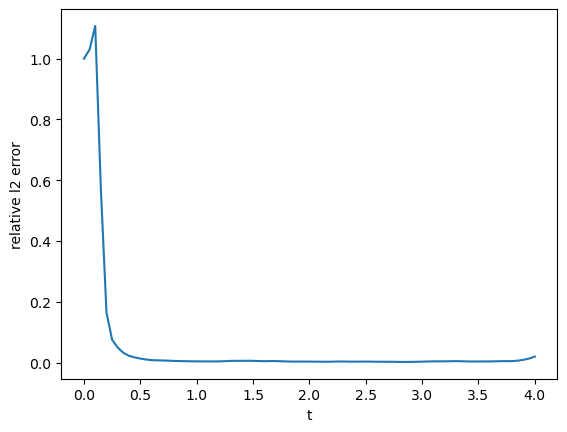

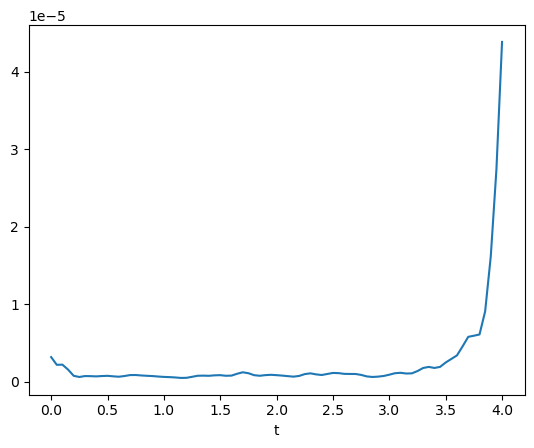

In [23]:
#calculate the relative l2 error 
rel_l2 = model.relative_l2_error
l2_error = []
MSe = []
for i in range(len(time_points)):
    l2_error.append(rel_l2(mean[i,:,:],u_matrix[:,:,i]))
    MSe.append(np.mean((mean[i,:,:]-u_matrix[:,:,i])**2))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time_points,l2_error)
ax.set_xlabel('t')
ax.set_ylabel('relative l2 error')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time_points,MSe)
ax.set_xlabel('t')



In [10]:
t = 80
rel_l2(mean[t,:,:],u_matrix[:,:,t])
np.mean((mean[t,:,:].ravel() - u_matrix[:,:,t].ravel())**2).item()

0.00029617577909820937

In [24]:
rel_l2(mean[:,:,:],u_matrix[:,:,:].T)

0.005654785510370278

In [14]:
fig, ax  = plt.subplots(1,2)
fig.tight_layout()
def frame(i):
    for a in ax:
        a.set_xlabel('x')
        a.set_ylabel('y')
    fig.suptitle(f't = ' + f"{time_points[i]:.2f}", fontsize=16)
    ax[0].clear()
    im = ax[0].imshow(mean[i,:,:].T, cmap='viridis', interpolation='nearest',vmin = -0.2, vmax = 0.2, extent=[0,2,0,2])
    ax[0].set_title("mean")
    
    ax[1].clear()
    im = ax[1].imshow(u_matrix[:,:,i], cmap='viridis', interpolation='nearest',vmin = -0.2, vmax = 0.2, extent=[0,2,0,2])
    ax[1].set_title("ground truth")
    
ani = FuncAnimation(fig, frame, frames=len(time_points), repeat=False)

ani.save('test3.mp4', writer='ffmpeg', fps=10)
plt.close()

In [16]:
fig, ax  = plt.subplots(1,2,figsize = (12,6), subplot_kw={"projection": "3d"})

def frame(i):
    for a in ax:
        a.set_xlabel('x')
        a.set_ylabel('y')
        a.set_zlabel('t')
    fig.suptitle('t = ' + f"{time_points[i]:.2f}", fontsize=12)
    ax[0].clear()
    im = ax[0].plot_surface(gx,gy,mean[i,:,:].T, cmap='viridis',vmin = -0.5, vmax = 0.5)
    ax[0].set_title("mean")
    ax[0].set_zlim(-0.8,0.8)

    ax[1].clear()
    im = ax[1].plot_surface(gx,gy,u_matrix[:,:,i], cmap='viridis',vmin = -0.5, vmax = 0.5)
    ax[1].set_title("ground truth")
    ax[1].set_zlim(-0.8,0.8)
ani = FuncAnimation(fig, frame, frames=len(time_points), repeat=False)

ani.save('3dplot.mp4', writer='ffmpeg', fps=10,dpi = 200)
plt.close()

(101, 101, 81)


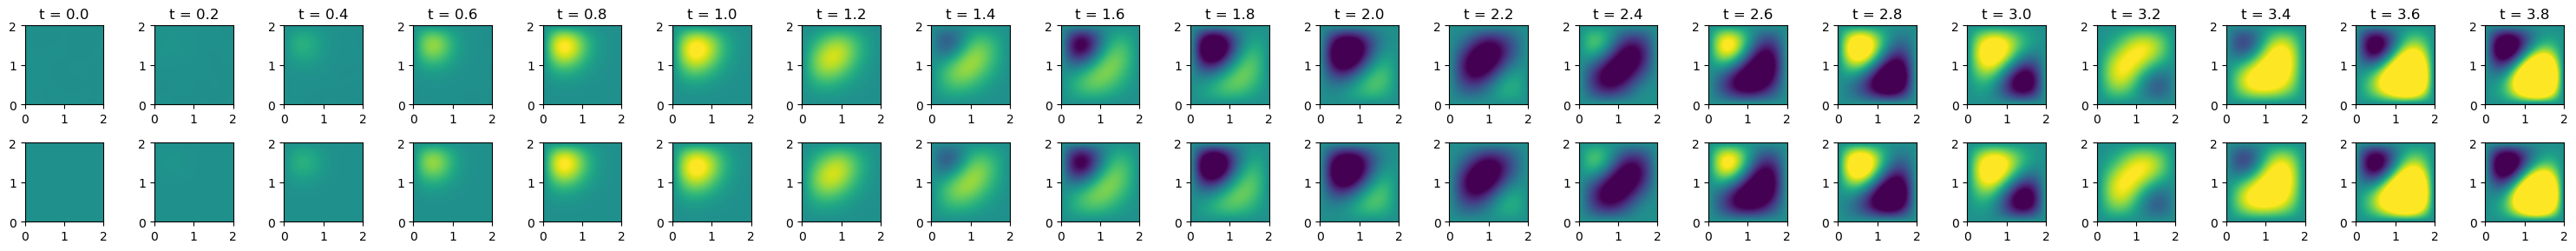

In [18]:
fig, ax = plt.subplots(2,20,figsize=(30,3))
ax = ax.flatten()
#split the ax
ax_1 = ax[:20]
ax_2 = ax[20:]
u_matrix = model.raw_data[2]
print(u_matrix.shape)
for i,t in zip(range(20),np.linspace(0, 2, len(u_matrix[0,0,:]))):
    
    im = ax_2[i].imshow(u_matrix[:,:,i*4].T, cmap='viridis',extent=[0,2,0,2],vmin = -0.5, vmax = 0.5)
    #plot the train points. we need to chekck for every t value and then plot the x,y coordinates
    #ax[i].scatter(x_train_u[t_train_u==i*5], y_train_u[t_train_u==i*5], color='red', marker='x', label='training points')
    ax_1[i].imshow(mean[i*4,:,:], cmap='viridis',extent=[0,2,0,2],vmin = -0.5, vmax = 0.5)

    #ax_1[i].set_xlabel('x')
    #ax_1[i].set_ylabel('y')
    ax_1[i].set_title('t = ' + str(np.round(time_points[i*4],4)), fontsize=12)
    #tight layout
    fig.tight_layout()

plt.savefig('wave_3d.png', dpi=300)

(101, 101, 81)


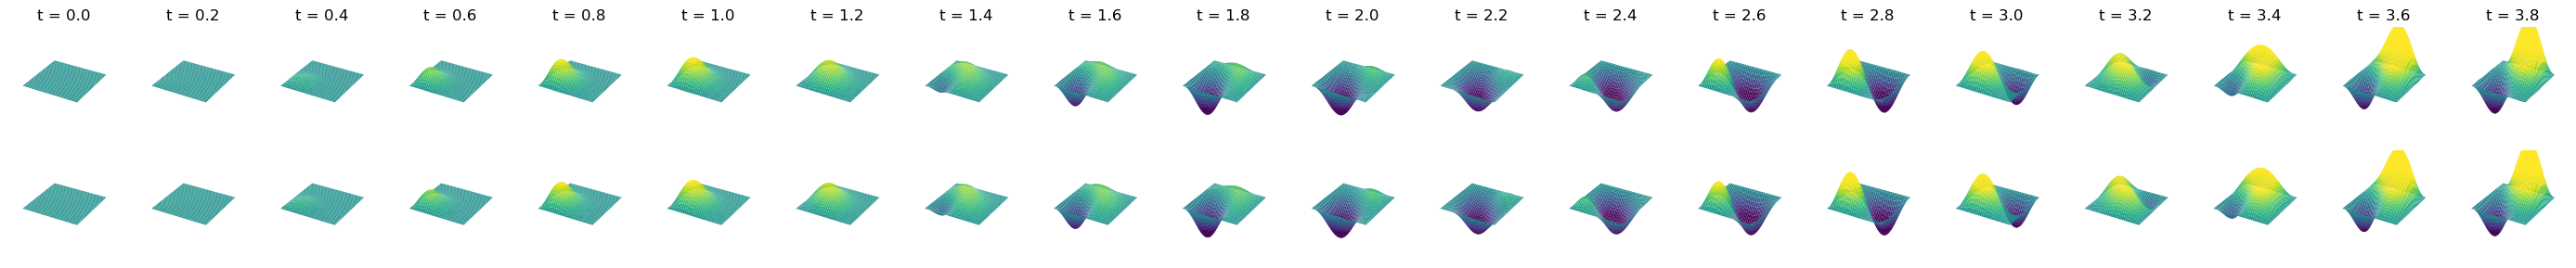

In [19]:
fig, ax = plt.subplots(2,20,figsize=(30,3),subplot_kw={"projection": "3d"})
ax = ax.flatten()
#split the ax
ax_1 = ax[:20]
ax_2 = ax[20:]
u_matrix = model.raw_data[2]
print(u_matrix.shape)
for i,t in zip(range(20),np.linspace(0, 2, len(u_matrix[0,0,:]))):
    im = ax_1[i].plot_surface(gx,gy,mean[i*4,:,:], cmap='viridis',vmin = -0.6, vmax = 0.6)
    ax_1[i].axis('off')
    ax_1[i].set_zlim(-0.8,0.8)
    ax_2[i].set_zlim(-0.8,0.8)

    im = ax_2[i].plot_surface(gx,gy,u_matrix[:,:,i*4], cmap='viridis',vmin = -0.6, vmax = 0.6)
    ax_2[i].axis('off')

    #ax_1[i].set_xlabel('x')
    #ax_1[i].set_ylabel('y')
    ax_1[i].set_title('t = ' + str(np.round(time_points[i*4],4)), fontsize=12)
    #tight layout
    fig.tight_layout()

plt.savefig('wave_3d_durfacec.png', dpi=300, bbox_inches='tight')

In [40]:
var = np.array(var)
var = var.reshape(len(time_points),grid_number,grid_number)
std = np.sqrt(var)

 /var/folders/5m/h4l2_hmn45j_y5q22rrhkpnr0000gn/T/ipykernel_45111/2514870824.py:3: RuntimeWarning:invalid value encountered in sqrt


(101, 101, 81)


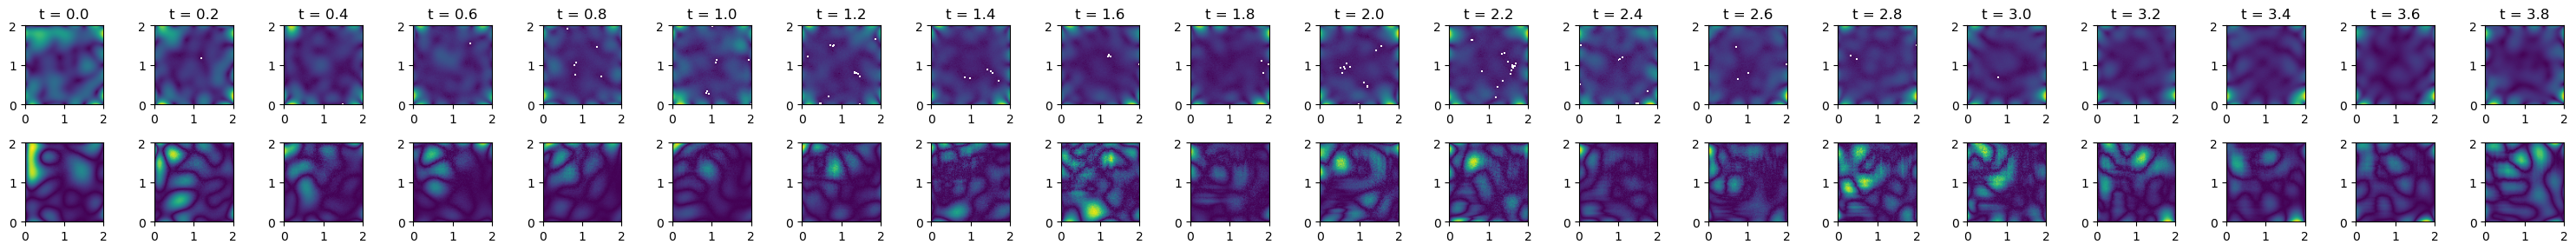

In [46]:
fig, ax = plt.subplots(2,20,figsize=(30,3))
ax = ax.flatten()
#split the ax
ax_1 = ax[:20]
ax_2 = ax[20:]
u_matrix = model.raw_data[2]
print(u_matrix.shape)
for i,t in zip(range(20),np.linspace(0, 4, len(u_matrix[0,0,:]))):
    
    im = ax_1[i].imshow(std[i*4,:,:].T, cmap='viridis',extent=[0,2,0,2])
    #plot the train points. we need to chekck for every t value and then plot the x,y coordinates
    #ax[i].scatter(x_train_u[t_train_u==i*5], y_train_u[t_train_u==i*5], color='red', marker='x', label='training points')
    ax_2[i].imshow(np.abs(mean[i*4,:,:]-u_matrix.T[i*4,:,:]), cmap='viridis',extent=[0,2,0,2])

    #ax_1[i].set_xlabel('x')
    #ax_1[i].set_ylabel('y')
    ax_1[i].set_title('t = ' + str(np.round(time_points[i*4],4)), fontsize=12)
    #tight layout
    fig.tight_layout()

In [69]:
X = model.X
import jax.numpy as jnp
def marg_log_likelihood(X, targets, params):
    K = k_uu(X, X, params) + 1e-6*np.eye(len(X))
    L = jnp.linalg.cholesky(K)
    alpha = jnp.linalg.solve(L.T, np.linalg.solve(L, targets))
    
    marg_log_likelihood = -1/2 * jnp.dot(targets.T,alpha) - np.sum(np.log(np.diagonal(L))) - len(X)/2 * np.log(2*np.pi)
    return marg_log_likelihood

from scipy.optimize import minimize
def minimize_log(X,targets):
    targets = targets.ravel()
    def marg_log_likelihood(params):

        K = k_uu(X, X, params)
        L = np.linalg.cholesky(K + 1e-6*np.eye(len(X)))
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, targets))
    
        marg_log_likelihood = 1/2 * np.dot(targets.T,alpha) + np.trace(np.log(L)) + len(X)/2 * np.log(2*np.pi)
        return marg_log_likelihood
    return marg_log_likelihood
theta = minimize(minimize_log(X,model.u_train), x0 = [0.1, 0.1, 0.1, 0.1], 
               bounds=((1e-5, None), (1e-5, None),(1e-5, None),(1e-5, None)),
               method='L-BFGS-B')
print(theta.x)
print(theta.fun)

def posterior_distribution(X, targets,x_test, params ):
    K = k_uu(X, X, params) 
    K_s = k_uu(X, x_test,params)
    K_ss = k_uu(x_test, x_test,params)

    L = jnp.linalg.cholesky(K + 1e-6*np.eye(len(X)))
    alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L, targets))

    f_star = jnp.dot(K_s.T, alpha)
    v = jnp.linalg.solve(L, K_s)
    var_f_star = K_ss - jnp.dot(v.T, v)
    
    return f_star, var_f_star

x = np.linspace(0,2,20).reshape(-1,1)
y = np.linspace(0,2,20).reshape(-1,1)
t = np.linspace(0,4,20).reshape(-1,1)

gx, gy, gt = np.meshgrid(x,y,t)

X_3d = np.c_[gx.ravel(), gy.ravel(), gt.ravel()]
x_test = np.c_[x.ravel(), y.ravel(), t.ravel()]
print(X_3d.shape)

f_star, var_f_star = posterior_distribution(X, model.u_train, X_3d, theta.x)
f_star.shape

f_star = f_star.reshape(20,20,2)
#var_f_star = var_f_star.reshape(20,20,20)



 /var/folders/5m/h4l2_hmn45j_y5q22rrhkpnr0000gn/T/ipykernel_39914/59975394.py:20: RuntimeWarning:divide by zero encountered in log
 /var/folders/5m/h4l2_hmn45j_y5q22rrhkpnr0000gn/T/ipykernel_39914/59975394.py:20: RuntimeWarning:invalid value encountered in log


[0.1 0.1 0.1 0.1]
-144.37189544607634
(8000, 3)


TypeError: reshape total size must be unchanged, got new_sizes (20, 20, 2) for shape (8000, 1).

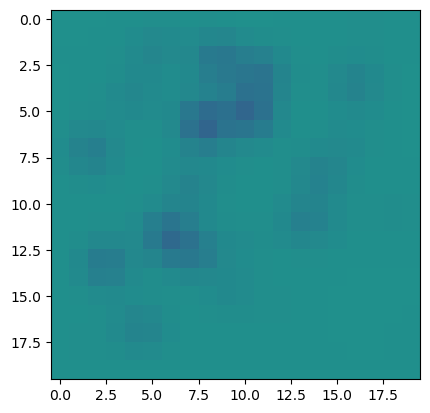

In [68]:
from matplotlib.animation import FuncAnimation
fig, ax  = plt.subplots()
def frame(t):
    ax.clear()
    im = ax.imshow(f_star[:,:,t], cmap='viridis', interpolation='nearest',vmin = -0.4, vmax = 0.4)

ani = FuncAnimation(fig, frame, frames=30, repeat=False)

ani.save('test.mp4', writer='ffmpeg', fps=10)

GP worked -932.6363525390625 [0.49959606732247214, 0.09878584827177633, 0.41479573778840956, 0.9925657694949922]
GP worked -562.71240234375 [0.24651005637443565, 0.007547282520288559, 0.4995287111486399, 0.8838582115467356]
GP worked 124.1395263671875 [0.18706236576520682, 0.07520011220433066, 0.38028924242175643, 0.25507919532165074]
GP failed
GP failed
GP failed
GP failed
GP failed
GP worked 118.33929443359375 [0.2725650825180607, 0.037858268459953076, 0.41052065783416325, 2.0107255627027216]
GP worked -378.0028076171875 [0.2973008693748486, 0.019764181167307052, 0.3562280094031482, 1.050432118463786]
GP failed
GP failed
GP worked -390.46875 [0.3061339366327205, 0.04880034302602662, 0.4315313051407992, 0.9253155240319718]
GP failed
GP failed
GP failed
GP failed
GP failed
GP failed
GP failed
GP worked 94.306640625 [0.34883649293621355, 0.15681427197360912, 0.4230938951071736, 1.361351409796309]
GP failed
GP failed
GP failed
GP failed
GP worked -186.0662841796875 [0.4223736616273647, 0

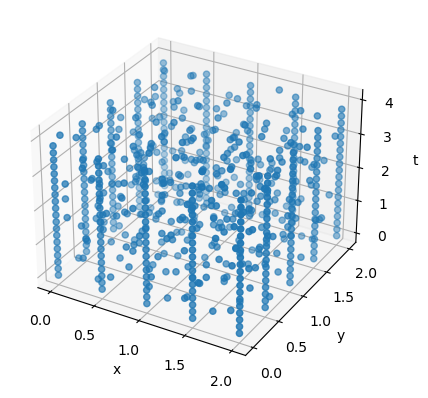

In [70]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x,y,t = model.X[:,0], model.X[:,1], model.X[:,2]

ax.scatter(x, y, t)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
plt.savefig("training_points.png",bbox_inches='tight')
plt.show()
